## snipgenie testing notebook

Updated files can be found here: https://github.com/dmnfarrell/gordon-group/tree/master/mbovis_annotation

links:

* https://github.com/JosephCrispell/GeneralTools/tree/master/ProcessingPipeline
* [Woodchester Park eLife paper](https://elifesciences.org/articles/45833)
* [An African origin for Mycobacterium bovis](https://academic.oup.com/emph/article/2020/1/49/5719036)
* http://www.htslib.org/doc/bcftools.html
* https://mtbgenomicsworkshop.readthedocs.io/
* [BCFtools cheat sheet](https://gist.github.com/elowy01/93922762e131d7abd3c7e8e166a74a0b)
* https://biopython.org/wiki/Category:Cookbook
* https://pyvcf.readthedocs.io/en/v0.4.6/INTRO.html
* https://gatkforums.broadinstitute.org/gatk/discussion/1268/what-is-a-vcf-and-how-should-i-interpret-it

In [2]:
import sys,os,shutil,subprocess
import random
import glob, time
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from gzip import open as gzopen
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
#from matplotlib_venn import venn2

## Mbovis samples from SRA

In [2]:
sra = pd.read_csv('../sra_mbovis_runtable.csv')

## Get master table with Loiseau et al. meta data¶

In [3]:
df = pd.read_excel('../Loiseau_TableS1.xlsx')
master = pd.merge(df,sra,left_on='BIOSAMPLE',right_on='BioSample',how='inner')
master.to_csv('../mbovis_sra_master.csv',index=False)
cols = ['Run','CLONAL_COMPLEX','COUNTRY_ISOLATION','LibraryLayout','Host','ReleaseDate','Bytes','Bases','GENOME_COVERAGE']
#master.columns
#master.geo_loc_name_country.value_counts()

## Representative samples of lineages

In [4]:
sub=master[(master.LibraryLayout=='PAIRED') & (master.COUNTRY_ISOLATION.notnull()) & (master.CLONAL_COMPLEX=='Eu2')]
#print (sub[cols])
#sub[cols].to_csv('../temp.csv')
accessions=['SRR1792002','SRR5216872','SRR5486071','ERR841808','ERR125601',
            'SRR8063654','SRR8063665','SRR8065079','SRR1791768','SRR1791960','ERR2815558']
testset = master[master.Run.isin(accessions)]
print (testset[cols])

             Run CLONAL_COMPLEX COUNTRY_ISOLATION LibraryLayout        Host           ReleaseDate        Bytes        Bases  GENOME_COVERAGE
36     ERR841808            Eu1                UK        PAIRED         Cow  2015-12-02T00:00:00Z  130651179.0  196040478.0            39.78
245   SRR5216872            Eu1       New Zealand        PAIRED      BOVINE  2017-01-31T00:00:00Z  194523112.0  295803584.0            41.39
464   SRR5486071       Unknown2          Ethiopia        PAIRED  Bos taurus  2017-04-28T00:00:00Z  251875435.0  445066100.0            50.71
677    ERR125601            Eu1           Ireland        PAIRED         NaN  2012-10-01T00:00:00Z  277182504.0  346340680.0            68.83
765   ERR2815558            Af1               NaN        PAIRED         NaN  2018-09-29T00:00:00Z  162711425.0  367702705.0            67.64
886   SRR1791768            Eu2            Canada        PAIRED      Cattle  2015-03-11T00:00:00Z  340596851.0  450406275.0            37.69
1076  SRR1791

In [ ]:
# fetch from SRA
def fetch_sra_reads(df,path):
    """download a subset of reads """
    
    for i,r in df.iterrows():
        files = glob.glob(os.path.join(path,r.Run+'*'))        
        if len(files)==0:
            cmd = 'fastq-dump --split-files {n} --outdir {o}'.format(n=r.Run,o=path)
            print (cmd)
            subprocess.check_output(cmd,shell=True)

fetch_sra_reads(testset,path='/storage/btbgenie/mbovis_sra')

## Blasting to known contaminants

* https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-2684-x#Sec2

In [ ]:
#get unmapped reads from a bam file

infile='mapped/3_S57_L001.bam'
cmd = 'samtools view -b -f 4 {i} > unmapped.bam'.format(i=infile)
print (cmd)
#align with bwa to known index of contaminants


## Examine FASTQ file quality and define trimming parameters

In [ ]:
reload(tools)

df = tools.fastq_to_dataframe(testfile)
df.length.hist()

In [ ]:
def trim_reads_default(filename, outfile, right_quality=30):
    """Trim adapters"""
        
    fastq_parser = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    c=0
    out = gzopen(outfile, "wt")
    for record in fastq_parser:
        score = record.letter_annotations["phred_quality"]         
        for i in range(len(score)-1,0,-1):
            if score[i] >= right_quality:
                break
        #trimmed.append(record[:i])
        #print (record[:i])        
        #c+=1
        #if c>100:
        #    break    
        SeqIO.write(record[:i],out,'fastq')
    return

testfile = 'mbovis_sra/SRR1791711_1.fastq.gz'
st=time.time()
trim_reads_default(testfile,'trimmed.fastq.gz')
print (time.time()-st)
df = tools.fastq_to_dataframe('trimmed.fastq.gz')
df.length.hist()

## multiprocess trimming

In [ ]:
def split_fastq(filename, chunks=4):
    """Split fastq file"""
    
    names=[]
    tmp = '/tmp'
    tmpfiles = []
    record_iter = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    length = 
    for i, batch in enumerate(tools.batch_iterator(record_iter, chunksize)):
        tempfile = "group_%i.fastq" % (i + 1)
        tmpfiles.append(tempfile)
        names.append(tempfile)
        with open(tempfile, "w") as handle:
            count = SeqIO.write(batch, handle, "fastq")
        print("Wrote %i records to %s" % (count, tempfile))
    return names

split_fastq(testfile)

In [ ]:
tools.plot_fastq_qualities(testfile,limit=100000)
plt.savefig('fastq_quals.png',dpi=100)
tools.plot_fastq_gc_content(testfile, limit=50000)
plt.savefig('gc.png',dpi=100)

## Get sample ids from fastq files

In [ ]:
path1='/storage/btbgenie/albania'
files = glob.glob(os.path.join(path1,'*.fastq.gz'))
path2='/storage/btbgenie/mbovis_sra'
files = glob.glob(os.path.join(path2,'*.fastq.gz'))
#add outgroup file
#files.append
files = app.get_files_from_paths([path1,path2])

df = app.get_samples(files)
df

## Align the FASTQ files against reference and create VCF files

In [ ]:
reload(aligners)
ref = app.mbovis_genome
samples = app.get_samples(files)
app.align_reads(samples, idx=ref, threads=10, overwrite=False)

## remove duplicated reads

In [ ]:
cmd = 'samtools rmdup A_reads.bt2.sorted.bam A_reads.bt2.sorted.noDups.bam'

## Keeping unmapped reads

https://gist.github.com/davfre/8596159

## variant calling

In [119]:
reload(app)
ref = app.mbovis_genome
bam_files = glob.glob('mapped/*.bam')
st=time.time()
vcf_file = app.variant_calling(bam_files, ref, 'mapped', threads=10, overwrite=True)
print (time.time()-st)

[      1  434991  869981 1304971 1739962 2174952 2609942 3044933 3479923
 3914913 4349904]
parallel bcftools mpileup -r {1} -a "AD,ADF,ADR,DP,SP,INFO/AD,INFO/ADF,INFO/ADR" -O b  --min-MQ 60 -o {2} -f /home/damien/.config/snpgenie/genome/Mbovis_AF212297.fa mapped/ERR551704.bam mapped/6_S7_L001.bam mapped/3_S57_L001.bam ::: "LT708304.1":1-434990 "LT708304.1":434991-869980 "LT708304.1":869981-1304970 "LT708304.1":1304971-1739961 "LT708304.1":1739962-2174951 "LT708304.1":2174952-2609941 "LT708304.1":2609942-3044932 "LT708304.1":3044933-3479922 "LT708304.1":3479923-3914912 "LT708304.1":3914913-4349903 :::+ /tmp/1.bcf /tmp/434991.bcf /tmp/869981.bcf /tmp/1304971.bcf /tmp/1739962.bcf /tmp/2174952.bcf /tmp/2609942.bcf /tmp/3044933.bcf /tmp/3479923.bcf /tmp/3914913.bcf
bcftools concat /tmp/1.bcf /tmp/434991.bcf /tmp/869981.bcf /tmp/1304971.bcf /tmp/1739962.bcf /tmp/2174952.bcf /tmp/2609942.bcf /tmp/3044933.bcf /tmp/3479923.bcf /tmp/3914913.bcf -O b -o mapped/raw.bcf
bcftools call -V indels --pl

## freebayes calling

In [204]:
fbcmd = 'freebayes'

ref=app.mbovis_genome
bam_files = glob.glob('mapped/*.bam')
print (bam_files)
out='mapped/freebayes.vcf'
cmd = '{fb} -p 2 -P 0 -C 2 -F 0.05 --min-coverage 10'\
         ' --min-repeat-entropy 1.0 -q 40 -m 20 --strict-vcf'\
        ' -f {r} -L files.txt > {o}'.format(r=ref,o=out,fb=fbcmd)        
print (cmd)

['mapped/ERR551704.bam', 'mapped/6_S7_L001.bam', 'mapped/3_S57_L001.bam']
freebayes -p 2 -P 0 -C 2 -F 0.05 --min-coverage 10 --min-repeat-entropy 1.0 -q 40 -m 20 --strict-vcf -f /home/damien/.config/snpgenie/genome/Mbovis_AF212297.fa -L files.txt > mapped/freebayes.vcf


In [ ]:
v1 = vcf_to_dataframe('result.vcf')
print (v1.var_type.value_counts())

In [ ]:
v2 = vcf_to_dataframe('mapped/raw.bcf')
print (v2.var_type.value_counts())

## filtering

```
FORMAT/AD   .. Allelic depth (Number=R,Type=Integer)
FORMAT/ADF  .. Allelic depths on the forward strand (Number=R,Type=Integer)
FORMAT/ADR  .. Allelic depths on the reverse strand (Number=R,Type=Integer)
FORMAT/DP   .. Number of high-quality bases (Number=1,Type=Integer)
FORMAT/SP   .. Phred-scaled strand bias P-value (Number=1,Type=Integer)
FORMAT/SCR  .. Number of soft-clipped reads (Number=1,Type=Integer)

INFO/AD     .. Total allelic depth (Number=R,Type=Integer)
INFO/ADF    .. Total allelic depths on the forward strand (Number=R,Type=Integer)
INFO/ADR    .. Total allelic depths on the reverse strand (Number=R,Type=Integer)
INFO/SCR    .. Number of soft-clipped reads (Number=1,Type=Integer)

FORMAT/DV   .. Deprecated in favor of FORMAT/AD; Number of high-quality non-reference bases, (Number=1,Type=Integer)
FORMAT/DP4  .. Deprecated in favor of FORMAT/ADF and FORMAT/ADR; Number of high-quality ref-forward, ref-reverse,
               alt-forward and alt-reverse bases (Number=4,Type=Integer)
FORMAT/DPR  .. Deprecated in favor of FORMAT/AD; Number of high-quality bases for each observed allele (Number=R,Type=Integer)
INFO/DPR    .. Deprecated in favor of INFO/AD; Number of high-quality bases for each observed allele (Number=R,Type=Integer)
```

Joe filters: DP - 30, DP4 - 4, MQ - 35, SUP - 0.95 and COV - 0.05. GQ and FQ = 0

## Other options

```
biallelic: -m2 -M2
uninformative sites, where the minor allele is present in at least one individual: --min-ac 1:minor
```

In [ ]:
import vcf
vcf_reader = vcf.Reader(open('mapped/filtered.vcf.gz', 'rb')) 
for record in vcf_reader:
    print (record)
    for sample in record.samples:
        print (sample)

In [ ]:
cmd = 'bcftools filter -e "QUAL<=40 && DP>=30 && DP4>=4 && MQ>=35" -o filtered.vcf.gz -O z mapped/calls.vcf'
print (cmd)
tmp = subprocess.check_output(cmd,shell=True)
v = vcf_to_dataframe('filtered.vcf.gz')
v.var_type.value_counts()

## consequence calling for vcf

In [94]:
reload(app)
ref=app.mbovis_genome
gff = '../snpgenie/data/Mbovis_csq_format.gff'
out = 'mapped/csq.tsv'
def csq_call():
    cmd = 'bcftools csq -f {r} -g {g} mapped/filtered.vcf.gz -Ot -o {o}'.format(r=ref,g=gff,o=out)
    print (cmd)
    tmp = subprocess.check_output(cmd,shell=True)
    
csq_call()

bcftools csq -f /home/damien/.config/snpgenie/genome/Mbovis_AF212297.fa -g ../snpgenie/data/Mbovis_csq_format.gff mapped/filtered.vcf.gz -Ot -o mapped/csq.tsv


In [ ]:
reload(app)
def read_csq_file(filename):
    cols = ['1','filename','2','chrom','start','snp_type','gene','locus_tag','strand','feature_type','aa','nuc',]
    csqdf = pd.read_csv(filename,sep='[|\t]',comment='#',names=cols, engine='python')
    return csqdf
csq = read_csq_file('csqout.tsv')
csq

In [5]:
def vcf_to_dataframe(vcf_file):
    """
    Convert a multi sample vcf to dataframe. Records each samples FORMAT fields.
    Args:
        vcf_file: input multi sample vcf
    Returns: pandas DataFrame
    """

    import vcf
    ext = os.path.splitext(vcf_file)[1]
    if ext == '.gz':
        file = gzopen(vcf_file, "rt")
    else:
        file = open(vcf_file)
    vcf_reader = vcf.Reader(file,'r')
    res=[]
    cols = ['sample','REF','ALT','mut','DP','ADF','ADR','AD','chrom','var_type',
            'sub_type','start','end','QUAL']
    i=0
    for rec in vcf_reader:
        #if i>50:
        #    break
        x = [rec.CHROM, rec.var_type, rec.var_subtype, rec.start, rec.end, rec.QUAL]
        for sample in rec.samples:
            if sample.gt_bases == None:
                mut=''
                row = [sample.sample, rec.REF, sample.gt_bases, mut, 0,0,0,0]
            elif rec.REF != sample.gt_bases:
                mut = str(rec.end)+rec.REF+'>'+sample.gt_bases
                cdata = sample.data
                row = [sample.sample, rec.REF, sample.gt_bases, mut, cdata[2], cdata[4] ,cdata[5], cdata[6]] + x
            else:
                mut = str(rec.end)+rec.REF
                #inf = sample.site.INFO
                cdata = sample.data
                row = [sample.sample, rec.REF, sample.gt_bases, mut, cdata[2], cdata[4] ,cdata[5], cdata[6]] + x

            res.append(row)
    res = pd.DataFrame(res,columns=cols)
    res = res[~res.start.isnull()]
    #res['start'] = res.start.astype(int)
    #res['end'] = res.end.astype(int)
    return res


## test filters

* https://samtools.github.io/bcftools/howtos/filtering.html

In [6]:
vdf = vcf_to_dataframe('test.vcf')
vdf

,sample,REF,ALT,mut,DP,ADF,ADR,AD,chrom,var_type,sub_type,start,end,QUAL
0,13-11594,A,G,1057A>G,78,"[0, 44]","[0, 33]","[0, 77]",LT708304.1,snp,ts,1056.0,1057.0,999.0
1,14-MBovis,A,G,1057A>G,114,"[1, 67]","[0, 46]","[1, 113]",LT708304.1,snp,ts,1056.0,1057.0,999.0
2,15-11643,A,G,1057A>G,96,"[0, 57]","[0, 39]","[0, 96]",LT708304.1,snp,ts,1056.0,1057.0,999.0
3,17-11662,A,G,1057A>G,98,"[0, 59]","[0, 39]","[0, 98]",LT708304.1,snp,ts,1056.0,1057.0,999.0
4,17-MBovis,A,G,1057A>G,64,"[0, 34]","[0, 30]","[0, 64]",LT708304.1,snp,ts,1056.0,1057.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16325,55-4348,G,A,4346083G>A,101,"[0, 66]","[0, 35]","[0, 101]",LT708304.1,snp,ts,4346082.0,4346083.0,211.0
16326,56-MBovis,G,G,4346083G,121,"[63, 0]","[58, 0]","[121, 0]",LT708304.1,snp,ts,4346082.0,4346083.0,211.0
16327,59-6110,G,G,4346083G,98,"[50, 0]","[44, 0]","[94, 0]",LT708304.1,snp,ts,4346082.0,4346083.0,211.0
16328,59-MBovis,G,G,4346083G,134,"[73, 0]","[61, 0]","[134, 0]",LT708304.1,snp,ts,4346082.0,4346083.0,211.0


In [ ]:
print (vdf[vdf.end==2839071])

In [24]:
vdf.groupby('end').agg({'DP':sum}).sort_values(by='DP')

,DP
end,
2799843.0,1
3673622.0,1
3673605.0,1
2799853.0,1
3488356.0,1
...,...
102980.0,6262
67098.0,6276
2592710.0,6704


In [ ]:
u = vdf.drop_duplicates(['sample','mut']).set_index(['mut','sample'])['ALT'].unstack('sample')
u[:30]

In [55]:
cmd = 'bcftools filter -e "QUAL<40 & FMT/DP<30" -o test.vcf.gz -O z test.vcf'
subprocess.check_output(cmd,shell=True)
fdf = vcf_to_dataframe('test.vcf.gz')
fdf[fdf.end==2839071]

,sample,REF,ALT,mut,DP,ADF,ADR,AD,chrom,var_type,sub_type,start,end,QUAL
5290,13-11594,C,G,2839071C>G,11,"[0, 8]","[1, 1]","[1, 9]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5291,14-MBovis,C,G,2839071C>G,12,"[0, 9]","[0, 3]","[0, 12]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5292,15-11643,C,G,2839071C>G,23,"[0, 13]","[0, 10]","[0, 23]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5293,17-11662,C,G,2839071C>G,6,"[1, 1]","[0, 4]","[1, 5]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5294,17-MBovis,C,G,2839071C>G,2,"[0, 2]","[0, 0]","[0, 2]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5295,182-MBovis,C,C,2839071C,104,"[67, 0]","[37, 0]","[104, 0]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5296,19-11957,C,G,2839071C>G,8,"[0, 6]","[0, 2]","[0, 8]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5297,19-MBovis,C,G,2839071C>G,4,"[0, 3]","[0, 0]","[0, 3]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5298,22-12200,C,G,2839071C>G,10,"[0, 3]","[0, 6]","[0, 9]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0
5299,23-MBovis,C,G,2839071C>G,11,"[0, 7]","[0, 4]","[0, 11]",LT708304.1,snp,tv,2839070.0,2839071.0,999.0


## Make fasta alignment from filtered VCF sites with multiple samples

https://github.com/JosephCrispell/GeneralTools/blob/master/ProcessingPipeline/CreateFastaWithReferenceFromFiltered_28-06-17.pl

"The allele frequencies at each position in the aligned (against reference) sequence from each isolate were examined. For a haploid organism these frequencies are expected to be either 0 or 1, with some random variation expected from sequencing errors (Sobkowiak et al., 2018). A heterozygous site was defined as one where the allele frequencies were >0.05 and <0.95. Four cattle-derived sequences that had more than 150 heterozygous sites, and allele frequencies that were clustered and non-random (data not shown), were removed. In addition, 26 badger-derived and 16 cattle-derived M. bovis sequences were removed because of suspected errors in the metadata (Appendix 1: Investigating isolate metadata discrepancies).

For the sequences from the remaining isolates (204 badger- and 169 cattle-derived isolates), alleles were called at each variant position if they had mapping quality ≥30, high-quality base depth ≥4 (applied to reverse and forward reads separately), read depth ≥30, and allele support ≥0.95. For any site that failed these criteria, if the allele called had been observed in a different isolate that had passed, a second round of filtering was conducted using a high-quality base depth of 5 (total across forward and reverse reads) and the same allele support. As recombination is thought to be extremely rare for mycobacteria (Namouchi et al., 2012), variants in close proximity could indicate a region that is difficult to sequence or under high selection. To avoid calling variants in these regions, variant positions within 10 bp of one another were removed. Following filtering, sequences from 11 badger and 10 cattle isolates that had insufficient coverage (<95%) of the variant positions were removed. Once the alignment was generated, sites with a consistency index less than 1, generally considered homoplasies (Farris, 1989), were removed (n = 4, of 14,991 sites) using HomoplasyFinder (v0.0.0.9; Crispell et al., 2019; RRID: SCR_017300). All the scripts necessary for the processing of the WGS data are freely available online."

In [42]:
def core_alignment_from_vcf(vcf_file, callback=None, uninformative=False, missing=False, omit=None):
    """
    Get core SNP site calls as sequences from a multi sample vcf file.
    Args:
        vcf_file: multi-sample vcf (e.g. produced by app.variant_calling)
        uninformative: whether to include uninformative sites
        missing: whether to include sites with one or more missing samples (ie. no coverage)
        omit: list of samples to exclude if required
    """

    import vcf
    from collections import defaultdict
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    #print (vcf_reader.samples)
    def default():
        return []
    result = defaultdict(default)
    sites = []
    result['ref'] = []
    missing_sites = []
    uninf_sites = []
    for record in vcf_reader:
        S = {sample.sample: sample.gt_bases for sample in record.samples}
        if omit != None:
            for o in omit:
                del S[o]
        #if any missing samples at the site we don't add
        if None in S.values():
            missing_sites.append(record.POS)            
            if missing == False:                
                continue
                
        #ignore uninformative sites
        if uninformative == False:
            u = set(S.values())
            if len(u) == 1:
                uninf_sites.append(record.POS)
                continue
        result['ref'].append(record.REF)
        #get bases over all samples
        for name in S:
            val = S[name]
            if val == None:
                val = 'N'
            result[name].append(val)
        sites.append(record.POS)
        
    sites = list(set(sites))
    print ('used %s sites for core snps' %len(sites))
    print ('%s sites with at least one missing sample' %len(missing_sites))
    if uninformative == False:
        print ('%s uninformative sites' %len(uninf_sites))
    if len(sites)==0:
        print ('no sites found may mean:\n'
         '- one sample is too different\n'
         '- few reads aligned due to poor coverage')
    recs = []
    for sample in result:
        seq = ''.join(result[sample])
        seqrec = SeqRecord(Seq(seq),id=sample)
        recs.append(seqrec)
        #print (len(seqrec))

    smat = pd.DataFrame(result)    
    smat.index = sites
    smat.index.rename('pos', inplace=True)
    smat = smat.sort_index()
    return recs, smat

seqrecs, smat = core_alignment_from_vcf('/storage/btbgenie/wicklow_results/snps.vcf.gz')
seqrecs, smat = core_alignment_from_vcf('/storage/btbgenie/wicklow_results/snps.vcf.gz', missing=True)


used 165 sites for core snps
9 sites with at least one missing sample
273 uninformative sites
used 174 sites for core snps
9 sites with at least one missing sample
273 uninformative sites


## filters

In [145]:
def site_proximity_filter(vcf_file, dist=10, overwrite=False, outdir=None):
    """Remove any pairs of sites within dist of each other"""

    import vcf
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    sites = [record.POS for record in vcf_reader]
    #print (sites)
    found = []
    for i in range(len(sites)-1):
        if sites[i+1] - sites[i] <= dist:
            #print (sites[i], sites[i+1],'close')
            found.extend([sites[i], sites[i+1]])
    #print (found)
    new = sorted(list(set(sites) - set(found)))
    print ('proximity filter found %s/%s sites' %(len(set(found)),len(sites)))
    if outdir == None:
        outdir = tempfile.gettempdir()
    if overwrite == True:
        out = os.path.join(outdir,'temp.vcf')
        vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
        vcf_writer = vcf.Writer(open(out, 'w'), vcf_reader)
        for record in vcf_reader:
            if record.POS in new:
                #print (record)
                vcf_writer.write_record(record)
        vcf_writer.close()
        #overwrite input vcf
        bcftoolscmd = tools.get_cmd('bcftools')
        cmd = 'bcftools view {o} -O z -o {gz}'.format(o=out,gz=vcf_file)
        tmp = subprocess.check_output(cmd,shell=True)
    return new

old = site_proximity_filter('/storage/btbgenie/sim_results/snps.vcf.gz')

proximity filter found 11/629 sites


In [133]:
df = tools.vcf_to_dataframe('/storage/btbgenie/sim_results/snps.vcf.gz') 
print (df[:4])
p=pd.pivot_table(df,index='pos',columns='sample',values='mut',aggfunc='size')
#p[p.isnull().sum(1)>0]

       sample REF ALT      mut   DP       ADF      ADR        AD       chrom var_type sub_type   pos   start     end   QUAL
0    13-11594   A   G  1057A>G  170  [0, 125]  [0, 45]  [0, 170]  LT708304.1      snp       ts  1057  1056.0  1057.0  999.0
1   14-MBovis   A   G  1057A>G  188  [0, 158]  [0, 30]  [0, 188]  LT708304.1      snp       ts  1057  1056.0  1057.0  999.0
2    15-11643   A   G  1057A>G  165  [0, 158]   [0, 7]  [0, 165]  LT708304.1      snp       ts  1057  1056.0  1057.0  999.0
3  161-MBovis   A   G  1057A>G  136  [0, 135]   [0, 1]  [0, 136]  LT708304.1      snp       ts  1057  1056.0  1057.0  999.0


In [112]:
fn = [2672966,2916881,3499480,3499469,3499476,2672970,2444846]

In [142]:
diff = list (set(new) - set(old))
sub=df[df.pos.isin(diff)]
p=pd.pivot_table(sub,index='pos',columns='sample',values='mut',aggfunc='first')
#import seaborn as sns
#sns.heatmap(p)
p.to_csv('proximity_changed.csv')

In [120]:
def overwrite_vcf(vcf_file, sites, outdir=None):
    """Make a new vcf with subset of sites"""
    
    if outdir == None:
        outdir = tempfile.gettempdir()
    
    out = os.path.join(outdir,'temp.vcf')
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    vcf_writer = vcf.Writer(open(out, 'w'), vcf_reader)
    for record in vcf_reader:
        if record.POS in sites:
            #print (record)
            vcf_writer.write_record(record)
    vcf_writer.close()
    #copy or overwrite input vcf
    bcftoolscmd = tools.get_cmd('bcftools')
    cmd = 'bcftools view {o} -O z -o {gz}'.format(o=out,gz=vcf_file)
    tmp = subprocess.check_output(cmd,shell=True)
    return

In [146]:
reload(tools)

def new_site_proximity_filter(vcf_file, dist=10, overwrite=False, outdir=None):
    """Remove any pairs of sites within dist of each other.
    Args:
        vcf_file: input vcf file with positions to filter
        dist: distance threshold
        overwrite: whether to overwrite the vcf
    """

    #get vcf into dataframe
    df = tools.vcf_to_dataframe(vcf_file)
    df = df[df.REF != df.ALT]
    sites = list(df.pos.unique())
    found = []
    #check distances in sites per sample
    for s, g in df.groupby(['sample']):
        #print (s)
        pos = list(g.pos)
        a = list(g.mut)   
        for i in range(len(pos)-1):
            #if pos[i] in fn:
                #print (s,pos[i],pos[i+1], pos[i+1] - pos[i],alt[i])
                #print (g[g.pos==pos[i]])            
            if pos[i+1] - pos[i] <= dist:
                found.extend([pos[i], pos[i+1]])
    #all unique positions    
    found = list(set(found))
    print (set(found).intersection(set(fn)))
    new = sorted(list(set(sites) - set(found)))
    print ('proximity filter found %s/%s sites' %(len(found),len(sites)))
    if overwrite == True:    
        overwrite_vcf(vcf_file, new, outdir)
    return new

new=new_site_proximity_filter('/storage/btbgenie/sim_results/snps.vcf.gz')

set()
proximity filter found 0/629 sites


## mask locations for mbovis

In [ ]:
#make mask bed file for mbovis
g=tools.genbank_to_dataframe('../snipgenie/data/Mbovis_AF212297.gb')
g['gene'] = g.gene.fillna('')
g=g[(g.gene.str.contains('PE_PGRS') | g.gene.str.contains('PPE')) & (g.feat_type=='CDS') | (g.feat_type=='repeat_region')]
for i,r in g.iterrows():  
    print ('LT708304.1','\t', r.start, '\t', r.end, r.gene, r.locus_tag)

## mask for MTB

In [ ]:
#make mask bed file for mbovis
g=tools.genbank_to_dataframe('../snipgenie/data/MTB-H37Rv.gb')
g['gene'] = g.gene.fillna('')
g=g[(g.gene.str.contains('PE_PGRS') | g.gene.str.contains('PPE')) & (g.feat_type=='CDS') | (g.feat_type=='repeat_region')]
for i,r in g.iterrows():  
    print ('NC_000962.3','\t', r.start, '\t', r.end)#, r.gene, r.locus_tag)

In [ ]:
def mask_filter(vcf_file, mask_file):
    """Remove any masked sites using a bed file, overwrites input"""

    print('using mask bed file', mask_file)
    mask = pd.read_csv(mask_file,sep='\t',names=['chrom','start','end'])    
    #print (mask)
    def do_mask(x,i):     
        #print (x.start, x.end, i)
        if (x.start<=i) & (x.end>=i):            
            return 1
    import vcf
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    sites = [record.POS for record in vcf_reader]
    found = []
    for i in sites:       
        m = mask.apply( lambda x: do_mask(x,i),1)        
        m = m[m==1]   
        if len(m)>0:    
            print (i)
            found.append(i)
    print('found %s sites in masked regions' %len(found))
    new = sorted(list(set(sites) - set(found)))
    
    tempdir = tempfile.gettempdir()
    out = os.path.join(tempdir,'temp.vcf')
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    vcf_writer = vcf.Writer(open(out, 'w'), vcf_reader)
    for record in vcf_reader:
        if record.POS in new:
            #print (record)
            vcf_writer.write_record(record)
    vcf_writer.close()
    #overwrite input vcf
    bcftoolscmd = tools.get_cmd('bcftools')
    cmd = 'bcftools view {o} -O z -o {gz}'.format(o=out,gz=vcf_file)
    tmp = subprocess.check_output(cmd,shell=True)
    return

mask_filter('mapped/filtered.vcf.gz','../snpgenie/data/Mbovis_AF212297_mask.bed')


## uninformative sites

probably not needed as we can use `--min-ac 1:minor`  in bcftools view?

In [237]:
def uninformative_sites_filter(vcf_file):
    """Ree"""

    import vcf
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    i=0; u=0
    for record in vcf_reader:
        ref=record.REF
        S = set([sample.gt_bases for sample in record.samples])
        #print (record.POS,ref,S)
        if (len(S)==1):
            #print (record.POS,ref,S)
            u+=1
        i+=1
    print (i,u)    
    
#u_filter('mapped/filtered.vcf.gz')
#u_filter('../test_results/filtered.vcf.gz')
uninformative_sites_filter('/storage/btbgenie/wicklow_results/filtered.vcf.gz')

629 78


In [210]:
def generic_multiprocess(inputs):
    #split sites into chunks and run in parallel for long jobs
    
    import multiprocessing as mp
    blocks = np.array_split(np.array(inputs),threads)
    result=[]
    funclist = []
    pool = mp.Pool(threads)
    for subset in blocks:            
        f = pool.apply_async(worker_func, [subset])      
        funclist.append(f)            
    try:
        for f in funclist:
            out = f.get(timeout=None)               
            if len(out)>0:
                result.append(out)
    except KeyboardInterrupt:
        print ('process interrupted')
        pool.terminate()
        sys.exit(0)

    pool.close()
    pool.join()    
    return result

### Phylogeny from MSA

In [ ]:
def run_RAXML(infile, name='variants', threads=8):
    """Run Raxml pthreads"""

    bootstraps = 10
    model = 'GTRCAT'
    s1 = random.randint(0,1e8)
    s2 = random.randint(0,1e8)
    
    files = glob.glob('RAxML_*')
    for f in files:
        os.remove(f)
    cmd = 'raxmlHPC-PTHREADS -f a -N {nb} -T {t} -m {m} -V -p {s1} -x {s2} -n {n} -s {i}'.format(t=threads,nb=bootstraps,n=name,i=infile,s1=s1,s2=s2,m=model)
    print (cmd)
    tmp = subprocess.check_output(cmd, shell=True)
    return
    
run_RAXML('variants.fa')

In [ ]:
def create_tree(filename, labelmap=None):
    """Draw a tree """
    
    from ete3 import Tree, NodeStyle, TreeStyle
    t = Tree(filename)
    t.set_outgroup('ref')    
    if labelmap != None:
        trees.set_tiplabels(t,labelmap)
    trees.format_nodes(t)
    ts = TreeStyle()
    ts.scale=1000
    t.render("%%inline", tree_style=ts)
    t.render("tree.png", tree_style=ts)
    return t

sra['filename'] = sra.Run.apply(lambda x: 'mapped/'+x+'.bam')
print (sra[:3])
labelmap = dict(zip(sra.filename,sra.geo_loc_name_country))
#print (labelmap)
t = create_tree('RAxML_bipartitions.variants', labelmap)
t.render("%%inline")

In [ ]:
from Bio import Phylo
tree=Phylo.read('RAxML_bestTree.variants','newick')
Phylo.draw(tree)

## csq gff format

In [ ]:
tools.gff_bcftools_format('../snpgenie/data/Mbovis_AF212297.gb', '../Mbovis_csq_new.gff')

In [ ]:
gff=tools.gff_to_features('../pathogenie/data/Mbovis_AF212297.gff')
g=tools.features_to_dataframe(gff)
tools.features_summary(g)

In [ ]:
reload(plotting)
f,ax=plt.subplots(1,1,figsize=(12,3))
st=time.time()
plotting.plot_bam_alignment('../test_results/mapped/3_S57_L001.bam', 'LT708304.1', 2000, 3000, yend=100, rect_height=3, ax=ax)
print (time.time()-st)

In [ ]:
def plot_features(rec, ax, rows=3, xstart=0, xend=30000):
    
    h=1
    df = tools.records_to_dataframe([rec])    
    df = df[(df.feat_type!='region') & (df['feat_type']!='source')]
    df = df[(df.start>xstart) & (df.end<xend)]
    df['length'] = df.end-df.start
    y = list(range(1,rows)) * len(df)
    df['y'] = y[:len(df)]
    df['color'] = 'blue'
    df = df.fillna('')
    #print (df)  
    
    from matplotlib.collections import PatchCollection
    import matplotlib.patches as mpatches

    patches=[]
    for i,r in df.iterrows():        
        #rect = plt.Rectangle((r.start, r.y), r.length, h/2,
        #                        alpha=.5, linewidth=.5,
        #                        edgecolor='black', facecolor=r.color)
        if r.strand == 1:
            x = r.start
            dx = r.length
        else:
            x = r.end
            dx = -r.length
        arrow = mpatches.Arrow(x, r.y, dx, 0, alpha=.7, width=.3, 
                               edgecolor='black')
        txt = ax.text(r.start, r.y-h/2, r.gene, size=16)
        patches.append(arrow)  
        
    ax.add_collection(PatchCollection(patches, match_original=True))  
    ax.set_xlim(xstart, xend)
    ax.set_ylim(.4,rows-.5)
    plt.yticks([])
    plt.tight_layout()

    def onclick(event):
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
              ('double' if event.dblclick else 'single', event.button,
               event.x, event.y, event.xdata, event.ydata))
        ax.text(event.x, event.y, 'HI!')
        ax.figure.canvas.draw()
    #cid = ax.figure.canvas.mpl_connect('button_press_event', onclick)
    return

reload(tools)
recs = tools.gff_to_records(app.mbovis_gff)
rec=recs[0]
f,ax=plt.subplots(1,1,figsize=(15,1.5))
plot_features(rec, ax=ax, xstart=26000,xend=35000)

## replace pysam

In [ ]:
def get_chrom(bam_file):
    """Get first sequence name in a bam file"""

    import pysam
    samfile = pysam.AlignmentFile(bam_file, "r")
    iter=samfile.fetch(start=0,end=10)
    for read in iter:
        if read.reference_name:
            return read.reference_name
        
get_chrom('mapped/3_S57_L001.bam')

In [4]:
import bamnostic as bs
bam = bs.AlignmentFile('mapped/3_S57_L001.bam', 'rb')

In [6]:
chrom=bam.header['SQ'][0]['SN']
chrom

'LT708304.1'

In [ ]:
for i, read in enumerate(bam.fetch(chrom, 1, 10)):
    print(read)

In [ ]:
def get_coverage(bam_file, chr, start, end):
    """Get coverage from bam file at specified region"""
    
    import bamnostic as bs
    if bam_file is None or not os.path.exists(bam_file):
        return
    bam = bs.AlignmentFile(bam_file, 'rb')
    for i, read in enumerate(bam.fetch(chrom, 1, 10)):
        print(read)
    return

get_coverage('mapped/3_S57_L001.bam', chrom, 1, 100)

In [ ]:
def samtools_flagstats(filename):
    """Parse samtools flagstat output into dictionary"""
    
    cmd = 'samtools flagstat %s' %filename
    tmp = subprocess.check_output(cmd, shell=True, universal_newlines=True)
    x = tmp.split('\n')    
    x = [int(i.split('+')[0]) for i in x[:-1]]
    #print (x)
    cols = ['total','secondary','supplementary','duplicates','mapped',
            'paired','read1','read2','properly paired','with itself','singletons']
    d = {}
    for c,v in zip(cols,x):
        d[c] = v
    return d

samtools_flagstats('mapped/6_S7_L001.bam')

In [ ]:
def samtools_tview(bam_file, chrom, pos, ref='', display='T'):
    """View bam alignment with samtools"""
    
    cmd = 'COLUMNS=150 samtools tview {b} -p {c}:{p} -d {d} {r}'.format(b=bam_file,c=chrom,p=pos,d=display,r=ref)
    #print (cmd)
    tmp = subprocess.check_output(cmd, shell=True, universal_newlines=True)    
    return tmp

t=samtools_tview('mapped/6_S7_L001.bam', 'LT708304.1', 1900, app.mbovis_genome)
print (t)

In [ ]:
def samtools_depth(bam_file, chrom, start, end):
    """Get depth from bam file"""

    cmd = 'samtools depth -r {c}:{s}-{e} {b}'.format(b=bam_file,c=chrom,s=start,e=end)
    tmp=subprocess.check_output(cmd, shell=True, universal_newlines=True)
    from io import StringIO
    c = pd.read_csv(StringIO(tmp),sep='\t',names=['chr','pos','depth'])
    return c
    
t=samtools_depth('mapped/6_S7_L001.bam', 'LT708304.1', 1900, 2000)
t

In [5]:
reload(tools)

def check_unmapped(fastafile):
    """Check possible source of unmapped reads"""
    
    recs=list(SeqIO.parse(fastafile,'fasta'))
    recs = recs[:900]
    SeqIO.write(recs,'temp.fa','fasta')
    tools.make_blast_database('contaminants.fa')
    bl = tools.blast_fasta('contaminants.fa', 'temp.fa',threads=8,show_cmd=True)    
    print (bl.stitle.value_counts())
    return bl

bl=check_unmapped('/storage/btbgenie/dup_results/unmapped/TB19-002014.bam.fasta')

blastn -out temp_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query temp.fa -db contaminants.fa -evalue 0.001 -max_target_seqs 50 -num_threads 8 -task blastn
LT708304.1 Mycobacterium bovis AF2122/97 genome assembly, chromosome: Mycobacterium_bovis_AF2122/97    932
NZ_CP021380.2 Pseudomonas aeruginosa strain CCBH4851 chromosome, complete genome                       240
Name: stitle, dtype: int64


In [7]:
bl.qseq.value_counts()

GCACAGATGGAACGGCTCGCGGTCCCCGACGA                                                                                                                           35
TCGTCGGGGACCGCGAGCCGTTCCATCTGTGC                                                                                                                           25
TTGAAGGTGTGGAAGAACTCCTCTTGAATACCCTCTTTGCCTTCAATGAATTGGATGTCGTCGACCAACAGCACGTCTACGTCGCGGTAGCTGCGTTTGAATGCG                                                  22
ACCAGC---CTTAACCGTCGCTACACCTTTGATACGTTCGTTATCGGCGCCTCCAACCGGTTCGCGCACGCCGCCGCCT                                                                            14
GTGTTGGCGTCGGCGATCAGATCGCGAAGCACAATCTCGGCCAGCGCTTTGTCGATTGGTGTTTTGTTCAATGAGGCGAACGCGGTGACCCGGATCAGCGCGCCCTCGAGTTCACGGATATTGCGTTCGATACTGCTGGCGATGAGTTCGA    11
                                                                                                                                                           ..
GATGAACAGGGGGTTGTAAGCGCGGGCGGGTGCTTCTGCGATCGCCAAGGCG

## find all multimapping regions in bam file

In [63]:
bf = '/storage/btbgenie/dup_results/mapped/TB19-003437.bam'
out = 'multimapped.bam'
threads=4
cmd = 'samtools view -@ {t} -b -f 256 -F 4 -h  {b} > {o}'.format(b=bf,o=out,t=threads)
subprocess.check_output(cmd,shell=True)


b''

In [64]:
import bamnostic as bs

In [ ]:
def get_multimapped():
    bam = bs.AlignmentFile('/storage/btbgenie/dup_results/mapped/TB19-003437.bam', 'rb')
    i=0
    rc=[]

    for read in bam:
        if i > 1000000:
            break
        #if read.mapq == 0:
        rc.append(read.pos)
        i+=1
    
get_multimapped()

In [78]:
%%time 
get_multimapped()

CPU times: user 1min 50s, sys: 47.8 ms, total: 1min 50s
Wall time: 1min 50s


In [79]:
x=pd.Series(rc)
x.value_counts()

608012     13
1342643    13
892029     12
1170985    11
608386     11
           ..
1343378     1
104339      1
104343      1
608153      1
401408      1
Length: 4109, dtype: int64

In [65]:
bam = bs.AlignmentFile('multimapped.bam', 'rb')
res=[]
for read in bam:
    res.append((read.pos,read.seq,read.mapq))
    

In [66]:
df=pd.DataFrame(res,columns=['pos','seq','qual'])

0          32
1306895    17
2767810     8
3080741     6
1306896     5
4317352     5
3351441     4
1306875     4
1306879     3
956926      3
Name: pos, dtype: int64

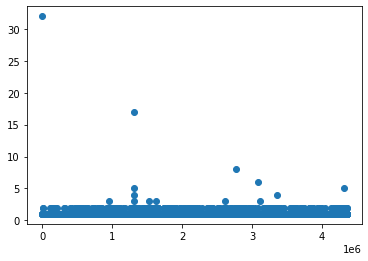

In [67]:
cts=df.pos.value_counts()
plt.scatter(x=cts.index,y=cts)
cts[:10]

## igv browser

In [34]:
import igv
ref = {
    "id": "AF212297",  
    "fastaURL": "Mbovis_AF212297.fa",
    "indexURL": "Mbovis_AF212297.fa.fai",  
  }

b = igv.Browser({"reference": ref})
b.load_track(
    {
        "name": "Local VCF",
        "url": "duplicate_test/snps.vcf.gz",
        "format": "vcf",
        "type": "variant",
        "indexed": False
    })

b.load_track(
    {
        "name": "TB19-002014",
        "url": "/storage/btbgenie/dup_results/mapped/TB19-002014.bam",
        "indexURL": "/storage/btbgenie/dup_results/mapped/TB19-002014.bam.bai",
        "format": "bam",
        "type": "alignment"
    })

In [ ]:
b.show()
b.zoom_in()

In [12]:
files=app.get_files_from_paths('/storage/btbgenie/mbovis_ireland/NI/')
df = app.get_samples(files)
df

,name,sample,filename,pair
0,ERR125601_1,ERR125601,/storage/btbgenie/mbovis_ireland/NI/ERR125601_...,1
1,ERR125602_2,ERR125602,/storage/btbgenie/mbovis_ireland/NI/ERR125602_...,1
2,ERR125614_1,ERR125614,/storage/btbgenie/mbovis_ireland/NI/ERR125614_...,1
3,ERR125624_2,ERR125624,/storage/btbgenie/mbovis_ireland/NI/ERR125624_...,1
4,ERR125611_2,ERR125611,/storage/btbgenie/mbovis_ireland/NI/ERR125611_...,1
...,...,...,...,...
57,ERR125627_2,ERR125627,/storage/btbgenie/mbovis_ireland/NI/ERR125627_...,2
58,ERR125606_2,ERR125606,/storage/btbgenie/mbovis_ireland/NI/ERR125606_...,2
59,ERR125619_1,ERR125619,/storage/btbgenie/mbovis_ireland/NI/ERR125619_...,2
60,ERR125603_2,ERR125603,/storage/btbgenie/mbovis_ireland/NI/ERR125603_...,2


In [26]:
p=pd.pivot_table(df,index='sample',columns='pair',values=['filename','name'],aggfunc='first')
c=list(zip(p.columns.get_level_values(0),p.columns.get_level_values(1)))
p.columns = [i[0]+str(i[1]) for i in c]
p=p.reset_index()

## low quality samples checks

In [1]:
args = {'threads':16, 'outdir': 'temp_results', 'labelsep':'_',  
        'input':['/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_06-10-22/'],
        'overwrite':False,
        'custom_filters': True,
        'mask': app.mbovis_mask,
        'unmapped': False,
        'buildtree': True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [52]:
import toytree, toyplot
treefile1 = '/storage/btbgenie/monaghan/temp_results/tree.newick'
tre = toytree.tree(treefile1)
canvas,t,r=tre.draw(layout='r',width=1200,height=900)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="900.0px" viewBox="0 0 1200.0 900.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te85ef8c1aa2043ddaf386512328ab762"> TB21-003501 TB20-007517 TB21-000767 TB20-010284 TB21-003503 TB21-003481 TB21-002988 TB20-006150 TB20-001123 TB21-003351 TB21-006021 TB20-009957 TB21-003754 TB21-003761 TB20-010495 TB20-008178 TB20-001076 TB20-013130 TB21-002445 TB21-003803 TB20-006503 TB21-002605 TB21-004113 TB21-005004 TB21-003810 TB20-010501 TB20-010290 TB20-007365 TB20-00383 TB20-007106 TB21-002572 TB21-002394 TB20-008488 TB21-005044 TB20-008255 TB21-001820 TB20-006477 TB21-005899 TB21-005814 TB21-002996 TB20-008482 TB21-002477 TB21-003550 TB20-008539 TB20-008494 TB21-001453 TB21-005756 TB21-004491 TB21-005048 TB21-006681 TB21-003857 TB21-004961 TB21-007218 TB21-002478 TB21-001822 TB21-006172 TB21-007003 TB21-005484 TB20-009946 TB20-007196 TB21-006183 TB21-005633 TB21-000372 TB21-003616 TB20-003017 TB21-002576 TB21-004763 TB21-006150 TB20-008480 TB21-009235 TB21-005040 TB20-008004 TB21-005761 TB21-004667 TB20-007397 TB21-005746 TB21-004455 TB20-001671 TB21-006176 TB20-007395 TB21-000716 TB21-004511 TB20-007352 TB20-009717 TB20-011683 TB20-008169 TB21-001382 TB21-002598 TB21-002581 TB21-005363 TB20-007880 TB20-007291 TB20-005224 TB21-006205 TB21-004516 ref

In [46]:
reload(tools)
seqrecs, smat = tools.core_alignment_from_vcf('/storage/btbgenie/monaghan/temp_results/snps.vcf.gz', missing=True)
SeqIO.write(seqrecs, 'core_test.fa','fasta')
treefile2 = trees.run_RAXML('core_test.fa', outpath='temp')

found 1646 sites for core snps
648 sites with at least one missing sample
31 uninformative sites
raxmlHPC-PTHREADS -f a -N 100 -T 8 -m GTRCAT -V -p 73564176 -x 61282166 -n variants -w /home/farrell/gitprojects/snipgenie/notebooks/temp -s core_test.fa


In [53]:
tre = toytree.tree(treefile2)
canvas,t,r=tre.draw(layout='r',width=1200,height=900)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="900.0px" viewBox="0 0 1200.0 900.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t17b534656ac044e8948db762778cb26a"> TB20-007365 TB20-00383 TB20-010501 TB20-010290 TB21-003810 TB21-002605 TB21-004113 TB21-005004 TB21-003761 TB21-003754 TB20-009957 TB21-006021 TB20-008178 TB20-010495 TB20-001076 TB20-013130 TB21-002445 TB21-002988 TB20-006150 TB20-001123 TB21-003351 TB21-003503 TB21-003481 TB20-010284 TB21-000767 TB21-003501 TB20-007517 TB20-008255 TB21-005044 TB20-008488 TB21-002572 TB20-007106 TB21-002394 TB21-003803 TB20-006503 TB21-005814 TB21-005899 TB21-001820 TB20-006477 TB21-002996 TB20-008482 TB20-008494 TB20-008539 TB21-001453 TB21-005756 TB21-004491 TB21-003550 TB21-002477 TB21-005048 TB21-006681 TB21-003857 TB21-004961 TB21-007218 TB21-002478 TB21-001822 TB20-009946 TB20-007196 TB21-005484 TB21-006172 TB21-005633 TB21-007003 TB21-000372 TB21-006183 TB21-004763 TB21-002576 TB20-003017 TB21-003616 TB21-006150 TB21-009235 TB20-008480 TB21-005040 TB20-008004 TB21-004516 ref TB21-005761 TB21-004667 TB20-009717 TB21-000716 TB20-007352 TB21-004511 TB20-007397 TB21-005746 TB21-004455 TB20-001671 TB21-006176 TB20-007395 TB21-002598 TB21-001382 TB20-008169 TB20-011683 TB21-002581 TB21-005363 TB20-007291 TB20-007880 TB20-005224 TB21-006205

<AxesSubplot:>

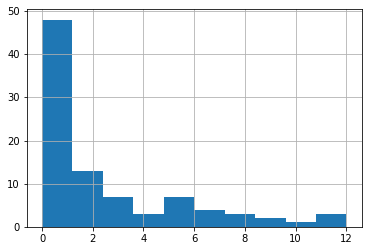

In [84]:
#missing sites per sample
missing=smat[smat=='N'].count().sort_values()
#print (missing)
#merge with coverage stats from run
samples=pd.read_csv('/storage/btbgenie/monaghan/temp_results/samples.csv')
x=samples.merge(missing.rename('missing'),right_index=True,left_on='sample')
sx=x[x.meandepth>5]
sx.missing.hist()

<AxesSubplot:xlabel='meandepth', ylabel='coverage'>

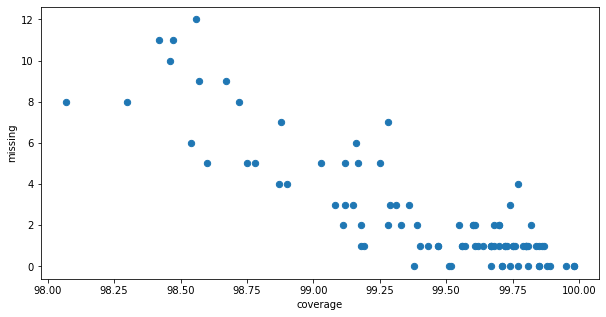

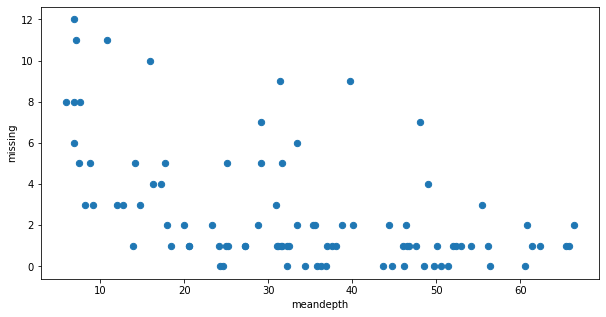

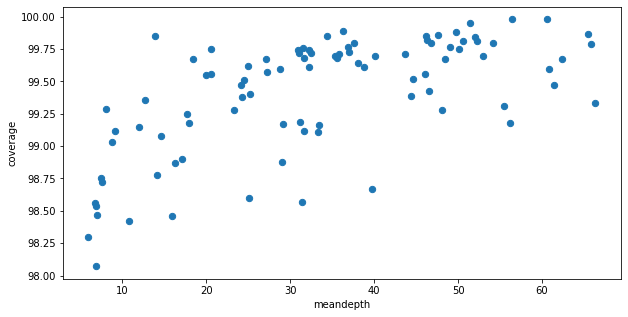

In [105]:
sx.plot('coverage','missing',kind='scatter',s=40,figsize=(10,5))
sx.plot('meandepth','missing',kind='scatter',s=40,figsize=(10,5))
sx.plot('meandepth','coverage',kind='scatter',s=40,figsize=(10,5))

In [73]:
x[['sample','missing','coverage','meandepth']].sort_values('missing',ascending=False)[:16]

,sample,missing,coverage,meandepth
63,TB21-003810,367,77.17,1.70
8,TB20-006503,249,82.35,2.01
21,TB20-008255,79,94.98,3.77
40,TB21-001453,42,96.66,4.76
81,TB21-005756,12,98.56,6.81
54,TB21-003351,11,98.42,10.81
71,TB21-004763,11,98.47,7.05
67,TB21-004491,10,98.46,15.96
37,TB21-000716,9,98.67,39.69
18,TB20-008004,9,98.57,31.40


In [91]:
#all monaghan
seqrecs, smat2 = tools.core_alignment_from_vcf('/storage/btbgenie/monaghan/monaghan_results/snps.vcf.gz', missing=True)
missingmon=smat2[smat2=='N'].count().sort_values()

found 2840 sites for core snps
462 sites with at least one missing sample
0 uninformative sites


<AxesSubplot:>

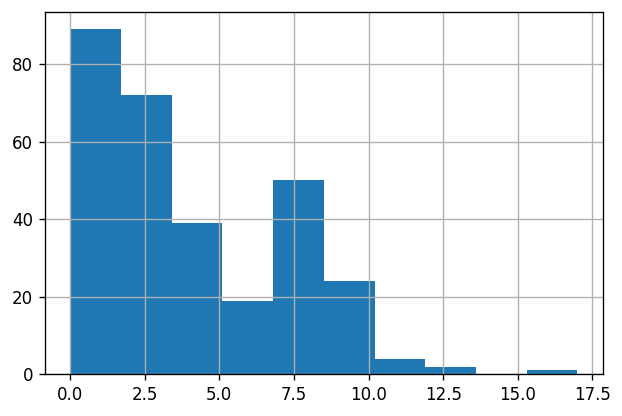

In [114]:
plt.rcParams['figure.dpi'] = 120
samples=pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/samples.csv')
monx=samples.merge(missingmon.rename('missing'),right_index=True,left_on='sample')
monsx=monx[monx.meandepth<100]
monsx.missing.hist()

<AxesSubplot:xlabel='meandepth', ylabel='coverage'>

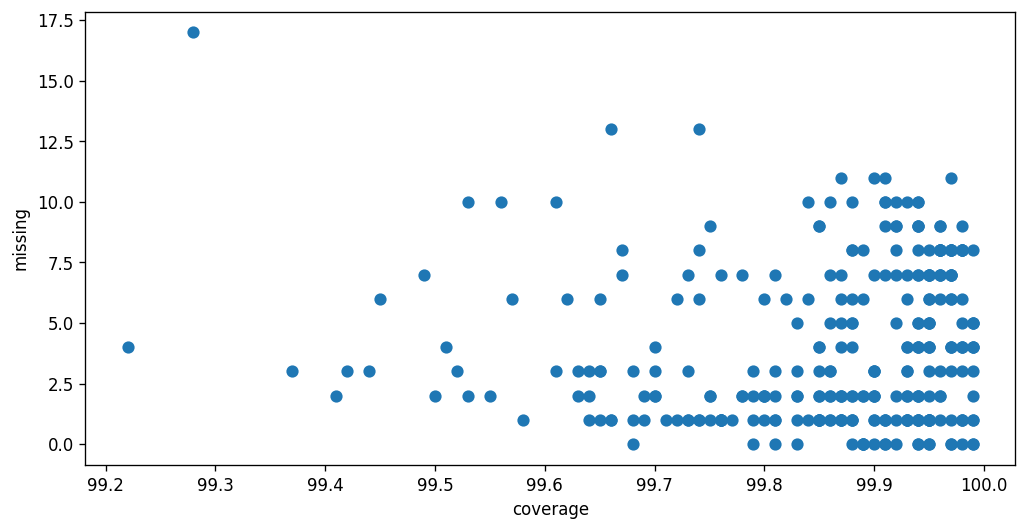

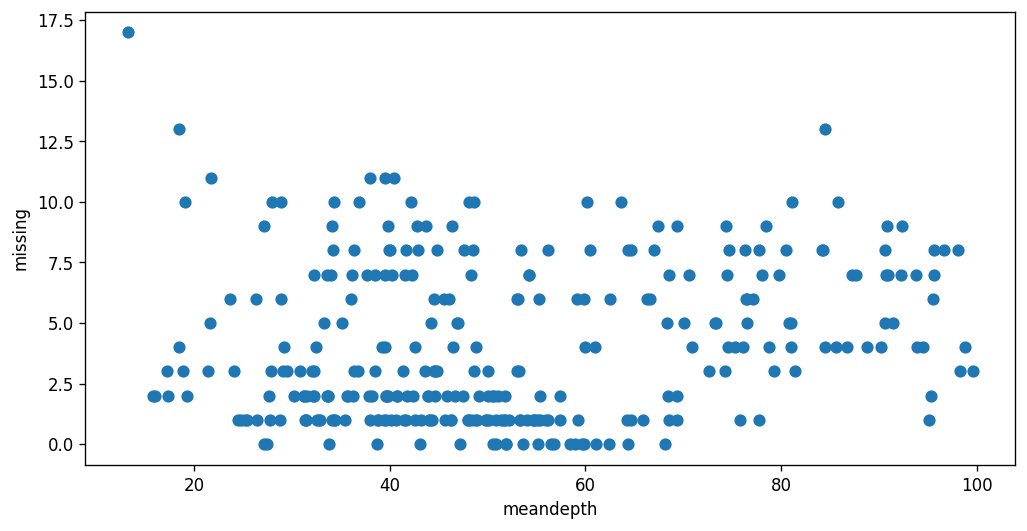

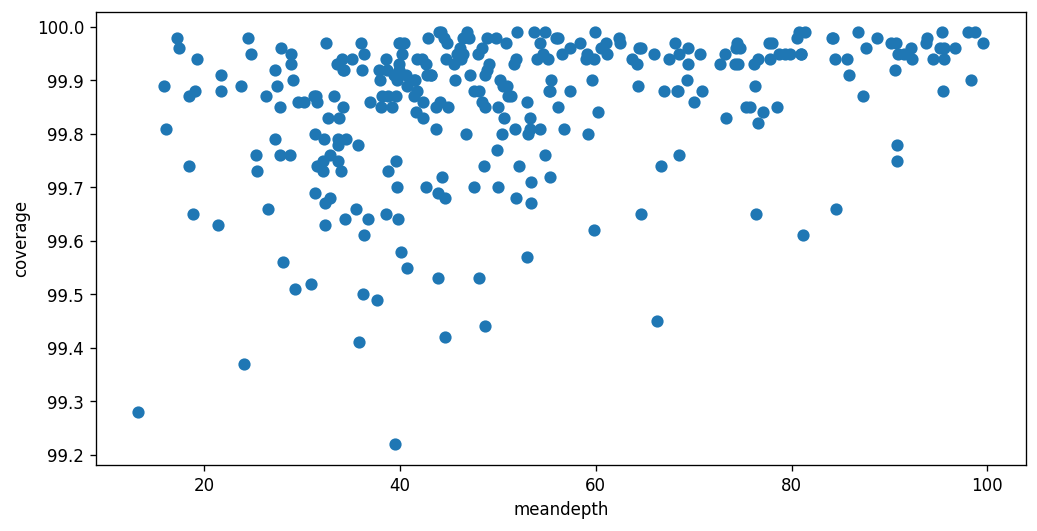

In [115]:
monsx.plot('coverage','missing',kind='scatter',s=40,figsize=(10,5))
monsx.plot('meandepth','missing',kind='scatter',s=40,figsize=(10,5))
monsx.plot('meandepth','coverage',kind='scatter',s=40,figsize=(10,5))